In [2]:
import redis
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from io import BytesIO

def load_from_redis(key):
    r = redis.Redis(host="127.0.0.1", port=6379)
    if r.exists(key):
        data = r.get(key)
        buf = pa.BufferReader(data)
        table = pq.read_table(buf)
        df = table.to_pandas()
        print(f"DataFrame loaded from Redis (key: {key}). Shape: {df.shape}")
        return df
    else:
        raise ValueError(f"No data found in Redis for key: {key}")

# Example usage
df = load_from_redis("usedcars_preprocessed_data")


DataFrame loaded from Redis (key: usedcars_preprocessed_data). Shape: (4009, 36)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def step_1_eda(df):
    print("\n=== Dataset Info ===")
    print(df.info())
    print("\n=== Descriptive Stats ===")
    print(df.describe())

# Run step 1
step_1_eda(df)



=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   model_year                    4009 non-null   int64  
 1   milage                        4009 non-null   float64
 2   accident                      4009 non-null   int64  
 3   clean_title                   4009 non-null   float64
 4   price                         4009 non-null   float64
 5   log_price                     4009 non-null   float64
 6   car_age                       4009 non-null   float64
 7   engine_hp                     4009 non-null   float64
 8   engine_displacement_L         4009 non-null   float64
 9   num_cylinders                 4009 non-null   float64
 10  is_turbo_supercharged         4009 non-null   int64  
 11  milage_per_year               4009 non-null   float64
 12  is_luxury                     4009 non-n

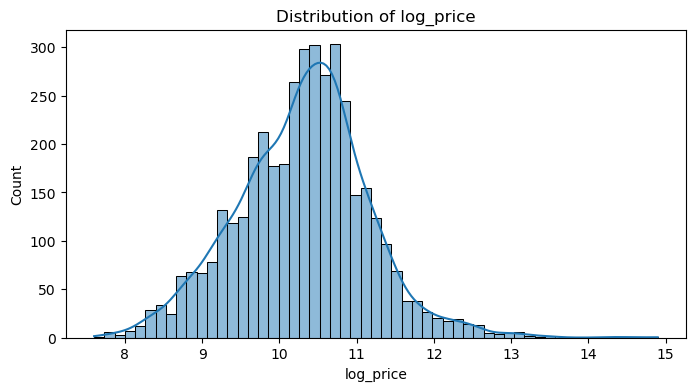

In [5]:
  # Target variable distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['log_price'], kde=True)
plt.title('Distribution of log_price')
plt.show()


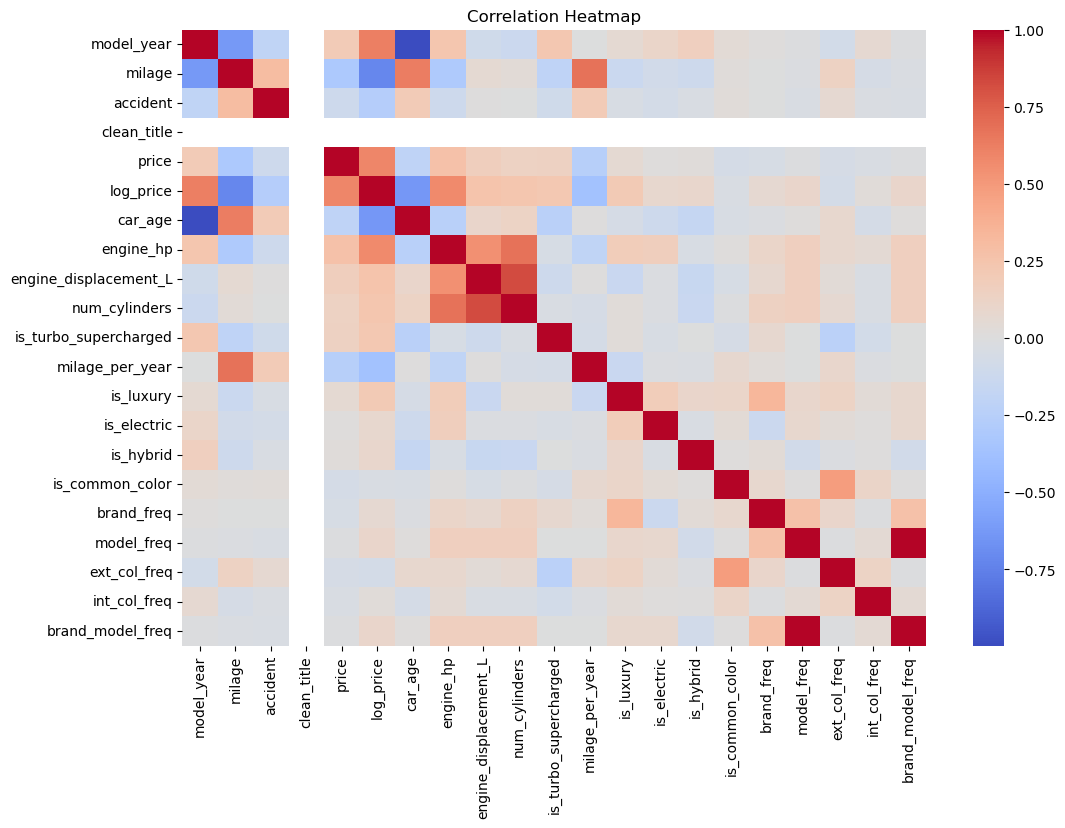

In [7]:
# Correlation heatmap (numerical)
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [15]:
# Top correlated features with target
print("\n=== Top features correlated with log_price ===")
print(corr['log_price'].sort_values(ascending=False).head(10))


=== Top features correlated with log_price ===
log_price                1.000000
model_year               0.625211
price                    0.594027
engine_hp                0.573624
engine_displacement_L    0.256221
num_cylinders            0.241404
is_turbo_supercharged    0.220425
is_luxury                0.210508
brand_model_freq         0.100730
model_freq               0.100466
Name: log_price, dtype: float64


In [10]:
# Detecting outliers via IQR method
numerical_cols = df.select_dtypes(include=[np.number]).columns
outlier_summary = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    outlier_summary[col] = outliers.sum()

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_df = outlier_df[outlier_df['Outlier Count'] > 0].sort_values(by='Outlier Count', ascending=False)
print("\n=== Outlier Counts by Feature ===")
    print(outlier_df)


=== Outlier Counts by Feature ===
                       Outlier Count
accident                         986
is_common_color                  398
model_freq                       347
brand_model_freq                 347
is_turbo_supercharged            309
price                            244
is_hybrid                        228
engine_hp                        174
is_electric                       90
car_age                           84
milage_per_year                   75
milage                            69
model_year                        67
log_price                         66


/tmp/ipykernel_15606/561420279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlier_df.index, y=outlier_df['Outlier Count'], palette='viridis')


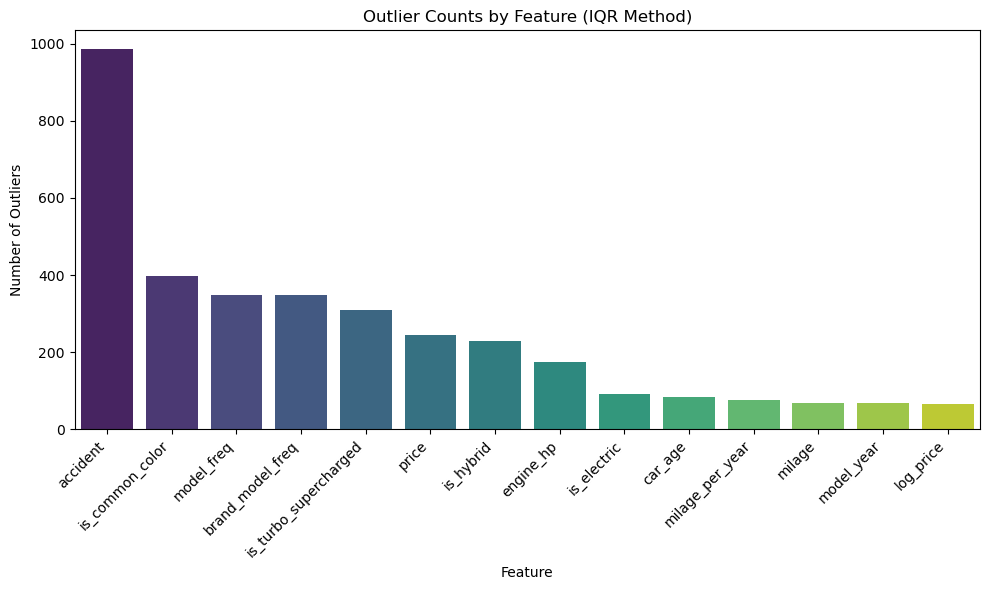

In [11]:
# Plotting the outlier counts as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=outlier_df.index, y=outlier_df['Outlier Count'], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Outlier Counts by Feature (IQR Method)')
plt.ylabel('Number of Outliers')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()
